# DTSA 5798 Final Project - Deep Learning with ktrain

## Setup

### Imports

In the following cell are the imports for this final project using ktrain.

There were issues with the original importing in the lecture example previously. These issues also applied to the final project. Students in the slack channel suggested making minor adjustments to the professor's import cell. The changes fixed the issues and are seen below.


In [ ]:
#Imports

import os
from sklearn.model_selection import train_test_split
!pip install tf-keras
os.environ['TF_USE_LEGACY_KERAS'] = '1'
try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import json
import numpy as np

### Google Drive Setup

Below is to mount Google Drive if not done so already.

In [ ]:
#Drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Directories

Below are the directories. The root directory is slightly different from the lectures. I've included the directories from lecture in case any one uses them similiarly during grading.

In [ ]:
#Directories

ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/1_text_classification"
DATA_DIR = "%s" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

### Data Read-In

Next, we will read in the data.

In [ ]:
#Reading in data

reviews = pd.read_json('%s/news_category_trainingdata.json' % DATA_DIR)

In [ ]:
#Information on data

reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


We can see that there are 200,853 different articles.

## Data Preparation


### Initial Data and Clean-Up

Below we can get a sense of the data we are working with. We can see the different columns and a few of the rows.

In [ ]:
#View of the dataframe

reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


As explained in lecture, we cannot have two separate columns of text for our model. We combine `headline` and `short_description` below.

In [ ]:
#Combine text columns

reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

Below, we can view the different categories included in the data. The project asks us to look at "health and wellness." We have two categories to consider: `HEALTHY LIVING` and `WELLNESS`.

In [ ]:
#View categories

reviews['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

Next, we will look at the articles in the dataframe with categories of `HEALTHY LIVING` and `WELLNESS`.

In [ ]:
#Focuses on rows where the category has to do with either health or wellness

reviews[reviews['category'].str.contains("HEALTHY LIVING|WELLNESS")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


We can see above that there are $24,521$ articles categorized as either `HEALTHY LIVING` or `WELLNESS`.

Next, we will create a column to indicate the article's category. `1` indicates that it is either `HEALTHY LIVING` or `WELLNESS`, while a `0` indicates that it is neither.

### New Category Column: `healthy_wellness`

In [ ]:
#Adds healthy_wellness column for category indication

reviews['healthy_wellness'] = np.where((reviews['category'] == 'HEALTHY LIVING') | (reviews['category'] == 'WELLNESS'), 1, 0)

We can take a look at the dateframe below in the next two cells. We see that we have 0's where we expect and 1's where we expect.

In [ ]:
#Checks first few rows (none of which are health or wellness)

reviews.head()

,category,headline,authors,link,short_description,date,combined_text,healthy_wellness
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [ ]:
#Looks at only health and wellness rows to verify 1's

reviews[reviews['category'].str.contains("HEALTHY LIVING|WELLNESS")]

,category,headline,authors,link,short_description,date,combined_text,healthy_wellness
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...,1
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1
...,...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...,1
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...,1
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...,1
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...,1


In [ ]:
#Overview of new column

reviews['healthy_wellness'].describe()

count    200853.000000
mean          0.122084
std           0.327384
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy_wellness, dtype: float64

### Balancing Data

Next, we will balance our data. Since there are $24,521$ articles about health or wellness, we will sample the same amount of articles we know are not about health or wellness.

In [ ]:
#Balances data evenly for health/wellness vs not health/wellness

#There are two different dataframes created

#Note, random_state is used here in case someone would like to reproduce the
#exact results

sample_amount = 24521
healthy_wellness = reviews[reviews['healthy_wellness'] == 1]
not_healthy_wellness = reviews[reviews['healthy_wellness'] == 0].sample(n = sample_amount, random_state = 1)

In [ ]:
#Combines the two dataframes

review_sample = pd.concat([healthy_wellness, not_healthy_wellness])

In [ ]:
#Overview of new dataframe after concatenation

review_sample

,category,headline,authors,link,short_description,date,combined_text,healthy_wellness
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...,1
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1
...,...,...,...,...,...,...,...,...
34384,POLITICS,Colorado County Funds College Scholarship With...,Ryan Grenoble,https://www.huffingtonpost.com/entry/pueblo-co...,"So far, taxing weed has raised about $425,000 ...",2017-02-14,Colorado County Funds College Scholarship With...,0
154943,WEDDINGS,Long Lost Love: Couple Reunited After 60 Years...,,https://www.huffingtonpost.com/entry/long-lost...,"Although Attebery liked Riggs, he never asked ...",2013-06-03,Long Lost Love: Couple Reunited After 60 Years...,0
20368,POLITICS,Etzioni’s Democratic Platform,"Amitai Etzioni, ContributorUniversity Professo...",https://www.huffingtonpost.com/entry/etzionis-...,We must start with a vision of the America we ...,2017-07-28,Etzioni’s Democratic Platform We must start wi...,0
10758,POLITICS,Supreme Court Hears Arguments In Major Privacy...,"Lawrence Hurley, Reuters",https://www.huffingtonpost.com/entry/supreme-c...,Justice Sonia Sotomayor noted that most Americ...,2017-11-29,Supreme Court Hears Arguments In Major Privacy...,0


Below we will check that the data is balanced. There should now be $2 \times 24521 = 49042$ articles in our new dataframe. The mean of our new categorical column should also be $0.5$.

In [ ]:
#Checks the balance of the data

review_sample['healthy_wellness'].describe()

count    49042.000000
mean         0.500000
std          0.500005
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: healthy_wellness, dtype: float64

Everything is balanced and we can proceed to modeling.

## Modeling

### Modeling Setup and Preprocessing

We first set our target names.

In [ ]:
#Sets target names

target_names = ['NOT HEALTHY WELLNESS','HEALTHY WELLNESS']

Next we will preprocess our data for our transformer model. The following line allows us to use our chosen pre-trained model. After looking into different pre-trained models, I decided to use DistilBERT due to it's speed. Some models may perform better, but they require more resources and time.

Below you can see how the hyperparameters were tuned. I also used `random_state` for reproducibility. I ended up reducing `max_features` considerably compared to our example from lecture. Similarly, I reduced `maxlen`. These were done with time constraints in mind, but ideally I would increase these if I had more time.

In [ ]:
#Preprocesses data as well as creates training and validation sets

train, val, preprocess = texts_from_df(review_sample, 'combined_text', label_columns = ['healthy_wellness'],
                                       val_df = None, max_features = 7000, maxlen = 256, val_pct = 0.1,
                                       ngram_range = 1, preprocess_mode = 'distilbert', verbose = 1,
                                       random_state = 1)

['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
93293                    1.0               0.0
102618                   0.0               1.0
163076                   1.0               0.0
92323                    0.0               1.0
176698                   1.0               0.0
['not_healthy_wellness', 'healthy_wellness']
        not_healthy_wellness  healthy_wellness
105572                   1.0               0.0
68795                    1.0               0.0
128634                   1.0               0.0
143079                   0.0               1.0
128266                   1.0               0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 69


### Model and Learner

Next, we create our model and learner.

In [ ]:
#Creates model from preprocessing
#Creates learner from model

model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data = train, val_data = val, batch_size = 16)

### Learning Rate and Loss Plot

In the next two cells we will obtain our learning rates and identify our optimal rate by looking at our plot.

In [ ]:
#Obtains Learning Rates

learner.lr_find(max_epochs = 6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
2758/2758 [==============================] - 630s 219ms/step - loss: 0.4830 - accuracy: 0.7864
Epoch 2/6
2758/2758 [==============================] - 610s 221ms/step - loss: 0.2375 - accuracy: 0.9076
Epoch 3/6
2758/2758 [==============================] - 610s 221ms/step - loss: 0.3833 - accuracy: 0.7957
Epoch 4/6
2758/2758 [==============================] - 603s 219ms/step - loss: 0.7525 - accuracy: 0.4981
Epoch 5/6
2758/2758 [==============================] - 0s 3us/step - loss: 27.9207 - accuracy: 0.7500


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


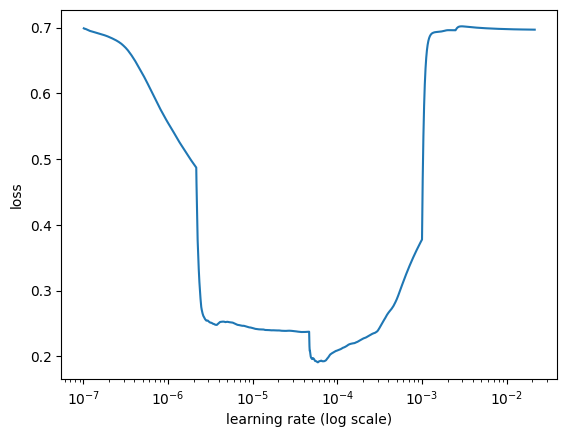

In [ ]:
#Plots Learning Rates

learner.lr_plot()

### Training

Now we move on to training.

In [ ]:
#Training

history = learner.autofit(1e-4, checkpoint_folder = 'checkpoint', epochs = 12, early_stopping = True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
2759/2759 [==============================] - 664s 230ms/step - loss: 0.2482 - accuracy: 0.9016 - val_loss: 0.2017 - val_accuracy: 0.9195
Epoch 2/12
2759/2759 [==============================] - 629s 228ms/step - loss: 0.1545 - accuracy: 0.9420 - val_loss: 0.2174 - val_accuracy: 0.9176
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
#Saves model to directory

learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)

In [ ]:
#Sets up and saves predictor to directory

predictor = ktrain.get_predictor(learner.model, preproc=preprocess)
predictor.save("%s/distilbertmodel_predictor")

### Validation Metrics

In [ ]:
#Looks at validation metrics

validation = learner.validate(val_data=val, print_report=True)

154/154 [==============================] - 27s 152ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2447
           1       0.90      0.94      0.92      2458

    accuracy                           0.92      4905
   macro avg       0.92      0.92      0.92      4905
weighted avg       0.92      0.92      0.92      4905



Since we are focused on contextual advertising in this project, we are focused on articles that our model predicts to be about healthy living or wellness. So we can focus on the `1` category. We see that precision is $90\%$, recall is $94\%$, and the F1-score is $92\%$. Additionally, accuracy is $92\%$.

## Professor's Test Set

Similar to what was done in lecture, we will test our model on the professor's test documents.

In [ ]:
#Test Documents used in Lecture

test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [ ]:
#Finds the probability for each test document

for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba = True)
  print("---------------------------")
  print('The probability this is health or wellness is %s' % probs[1])
  print(text)

---------------------------
The probability this is health or wellness is 0.9934517
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is health or wellness is 0.97890913
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is health or wellness is 0.89225125
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is health or wellness is 0.91530883
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is health or wellness is 0.001749792
Cuomo Will N

We can see above that the model performs very well. The first 4 articles are correctly predicted to be about health or wellness. The last 2 articles are correctly predicted to not be about health or wellness.

Next, we will look at the trickier test document that the professor included and see how our model performs.

In [ ]:
#Another test from lecture

lastprob = predictor.predict('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.', return_proba = True)
print('The probability this is health or wellness is %s' % lastprob[1])

The probability this is health or wellness is 0.36665297


We can see that the probability is about 0.3667, meaning our model correctly predicts this article is not about health or wellness.

## Conclusion

I learned a lot over the course of this project. It was a great opportunity to practice more of what was covered in lecture.

Overall I am happy with the performance of the model, considering that hyperparameters were also tuned with regards to time constraints instead of only model performance. The validation metrics were rather high considering these aspects. The model also correctly predicted that the trickier document was not about health or wellness.

There is room for improvement. Change in hyperparameter values could lead to better models and results. The probabilities from the test set could be better and benefit from these changes.